In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io
from pathlib import Path
from PIL import Image
import torchvision.utils as vutils
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
from tqdm.notebook import tqdm
import math
from sklearn.metrics import accuracy_score
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
image_size = 224
std,mean = [0.229, 0.224, 0.225],[0.485, 0.456, 0.406] # pretrained models used these values
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,
                         std=std)
])

In [4]:
def imshow(img, title='', std=std, mean=mean,figsize=(16,16)):
    img = img.permute(1,2,0).cpu()
    img = img * torch.tensor(std) + torch.tensor(mean)
    img = np.clip(img, 0, 1)
    plt.figure (figsize = figsize)
    plt.imshow(img)
    plt.title(title)

In [5]:
class IFoodDataset(Dataset):
    def __init__(self, labels_csv, data_path, transforms):
        self.labels_df = pd.read_csv(labels_csv)
        self.data_path = root_path / data_path
        self.compose = transforms
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_name = self.data_path/self.labels_df.iloc[idx, 0]
        image = io.imread(img_name)
        image = Image.fromarray(image)
        image = self.compose(image)
        return {'image':image,'label':self.labels_df.iloc[idx, 1]}

In [9]:
bs=128
root_path = Path.cwd() / 'ifood'
train_labels_csv = 'train_labels.csv'
train_data_path = 'train_set'
dataset = IFoodDataset(root_path/train_labels_csv, root_path/train_data_path, test_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=False,num_workers=4)

In [10]:
class EmbeddingExtractor:
    def sniff_output(self,model, input, output):
        self.embeddings=output  
    def __init__(self):
        self.model = models.resnet34(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, 251)
        self.model = self.model.to(device)
        self.model.load_state_dict(torch.load('model.pt'))
        self.model.eval()
        layer = self.model._modules.get('avgpool')
        self.handle = layer.register_forward_hook(self.sniff_output)
    def get_embeddings(self, input):
        with torch.no_grad():
            self.model(input.to(device))
        return self.embeddings.squeeze(-1).squeeze(-1)
extractor = EmbeddingExtractor()

In [11]:
#calculate all embeddings for trainset
all_emb=torch.tensor([])
for i,batch in enumerate(tqdm(dataloader)):
    emb = extractor.get_embeddings(batch['image'].to(device)).detach().cpu()
    all_emb=torch.cat([all_emb,emb],dim=0)

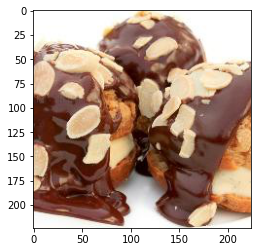

In [14]:
target_id = 4521
imshow(dataset[target_id]['image'],figsize=(4,4))

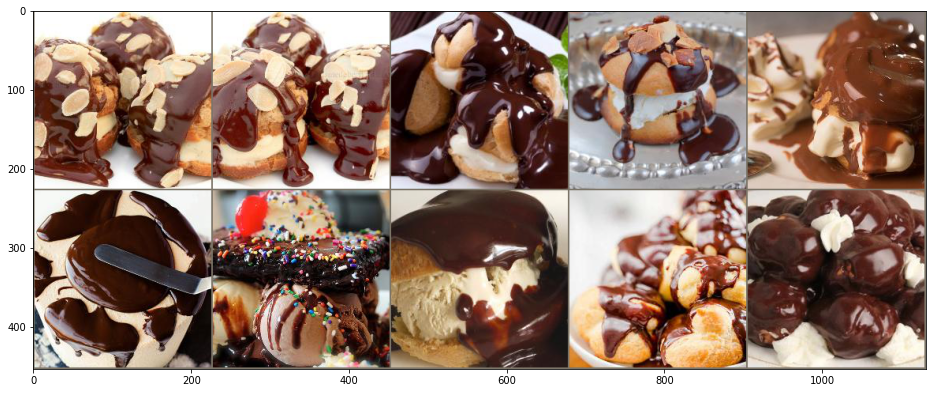

In [16]:
target_emb = extractor.get_embeddings(dataset[target_id]['image'].unsqueeze(0)).squeeze(0)
#euclidean distance to all other embeddings:
distances = (torch.pow(target_emb.cpu()-all_emb,2)).sum(dim=1).sqrt()
top_results = distances.argsort(descending=False)[:10]
top_images = torch.stack([dataset[i.item()]['image'] for i in top_results])
imshow(vutils.make_grid(top_images, nrow=5, padding=2))

In [18]:
def display_best_images(feature_index):
    top_ten = sorted(range(len(all_emb)), key=lambda k: all_emb[k][feature_index].item(),reverse=True)[:10]
    top_images = torch.stack([dataset[i]['image'] for i in top_ten])
    imshow(vutils.make_grid(top_images, nrow=5, padding=2),f'index={feature_index}')

In [ ]:
for i in tqdm(range(300,500)):
    display_best_images(i)

/home/yonatang/venv/lib64/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


In [ ]:
2,86